This is notebook provides some exploratory data analysis on the dataset of bicycle trips of the Citibike network (https://www.citibikenyc.com/system-data). 

In [71]:
# Define a function for a quick installation procedure. 
import pip

def install(package):
   pip.main(['install', package])

# Use like this for example: 

# install('requests') 

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
# import the packages that we will be using. If not installed, use the function defined above.
import numpy as np
import pandas as pd
import os as os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math

In [37]:
# check data types for possible inaccurate type recognition
data.dtypes

tripduration                        int64
starttime                          object
stoptime                           object
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                         object
gender                              int64
Starttime_formatted        datetime64[ns]
Stoptime_formatted         datetime64[ns]
dtype: object

Variable types seem to assume correct types, no need to force convert. 

In [36]:
# recode the format of time from object (string) to datetime format
data['Starttime_formatted'] = pd.to_datetime(data['starttime'])
data['Stoptime_formatted'] = pd.to_datetime(data['stoptime'])

In [27]:
# This code segments reads all of the files which end with .csv. 
# It pressuposes that our current working directory is the folder with the files.
# For demonstration purposes we will only read the first file (dataset of July 2013) since the whole dataset 
# takes up ~ 6 Gb of space and the analysis on the complete dataset is thus very time-consuming.
data = pd.DataFrame()
for file in os.listdir():
    if file.endswith(".csv"):
        data = pd.read_csv(file)
        break

In [13]:
#this funciton selects data between two given timesets (in datetime.time format) and type of the day (weekday, weekend or unspecified)
def selecttime(data, starttime, endtime, dayoftheweek = 'all'):
# first calculate time of the day, in order to avoid recalculatin in each if statement
    data['start_time_of_the_day'] = data['Starttime_formatted'].apply(lambda x: x.time())
    data['stop_time_of_the_day'] = data['Stoptime_formatted'].apply(lambda x: x.time())
    if dayoftheweek == 'weekday':
        temp = data[ (data['start_time_of_the_day'] > starttime) 
                    &(data['stop_time_of_the_day'] < endtime)
                    &(data['Starttime_formatted'].apply(lambda x: x.weekday() <5 ))]
    else:
        if dayoftheweek  == 'weekend':
            temp = data[ (data['start_time_of_the_day'] > starttime) 
                    &(data['stop_time_of_the_day'] < endtime)
                    &(data['Starttime_formatted'].apply(lambda x: x.weekday() > 5 ))]
        else:
            temp = data[ (data['start_time_of_the_day'] > starttime) 
                    &(data['stop_time_of_the_day'] < endtime)]
    return temp


# data is numpy array, return is the array of percentiles
def plot_percentiles(data):
    quantiles = np.percentile(data, np.arange(1,100,1))
    g = sns.barplot(np.arange(1,100,1), quantiles)
    g.set(xticklabels=[]) # remove ticks, otherwise they roll on each other
    plt.show()
    # Print 25th, 50th, 75th and 100th percentiles
    print(np.percentile(data, np.arange(25,125,25)))

# groups input data by the input key, calculates mean and plots the percentile distribution of mean, returns the array of the percentiles
def plot_groupby_mean_percentiles(data, group_by, subject): 
    templist = []
    temp = data.groupby(group_by)
    for i in data[group_by].unique():
        templist.append(temp.get_group(i)[subject].mean())
    temparray = np.array(templist)
    plot_percentiles(temparray)
    return temparray
    

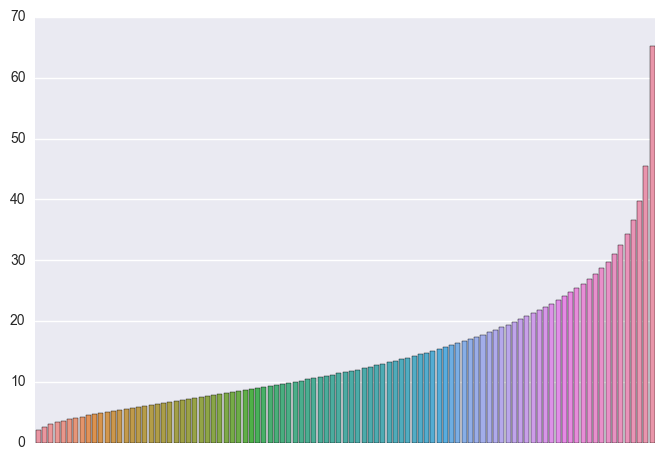

[  7.23333333e+00   1.16333333e+01   1.90000000e+01   1.04179167e+05]


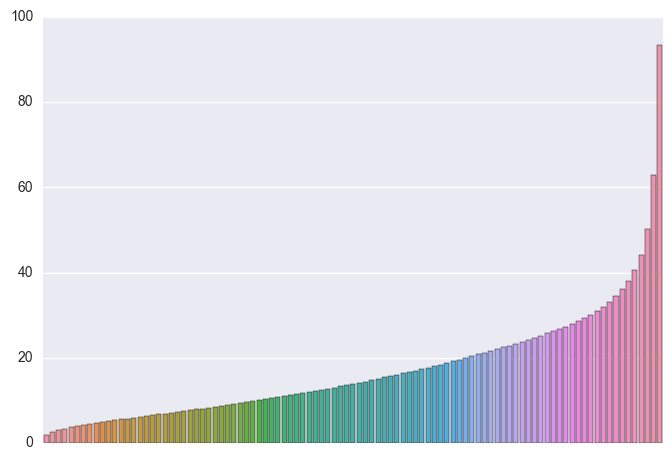

[    7.88333333    13.86666667    22.86666667  1820.11666667]


In [14]:
# Here we plot two graphs of tripduration percentile distribution for the weekdays and on weekends around the clock.
# divide by 60 to get minutes
plot_percentiles(selecttime(data, datetime.time(0,0,0), datetime.time(23,0,0), 'weekday')['tripduration'] /60) 
plot_percentiles(selecttime(data, datetime.time(0,0,0), datetime.time(23,0,0), 'weekend')['tripduration'] /60)


We can see from the graphs, that while the distributions of tripduration on weekdays and weekends look laregely the same, the demonstrate some differences in absolute terms - for example, the mean value for tripduration on a weekday is 16 minutes, while the same indicator for weekends is 13.8. We can also notice that while the maximum value for tripduration on weekends is 1820 minutes (30 hours), on weekdays it reaches 104179 minutes (29 days), which might signify a very distant outlier or a mistake in the time logging system. Let us look at the 99th percentiles for both weekdays and weekends.

In [15]:
print(np.percentile(selecttime(data, datetime.time(0,0,0), datetime.time(23,0,0), 'weekday')['tripduration'] /60, 99))
print(np.percentile(selecttime(data, datetime.time(0,0,0), datetime.time(23,0,0), 'weekend')['tripduration'] /60, 99))

65.2166666667
93.364


Here we see, that 99% of all trips on weekdays end before 66 minutes have elapsed, while 99% of all trips on weekends end before 94 minutes. This further demonstrates that the extreme figures of the maximum amount of time used are very much outliers.

We now group the dataset by bike id in order to see the distribution of usage of individual bicycles.

In [16]:
bikes = data.groupby('bikeid')

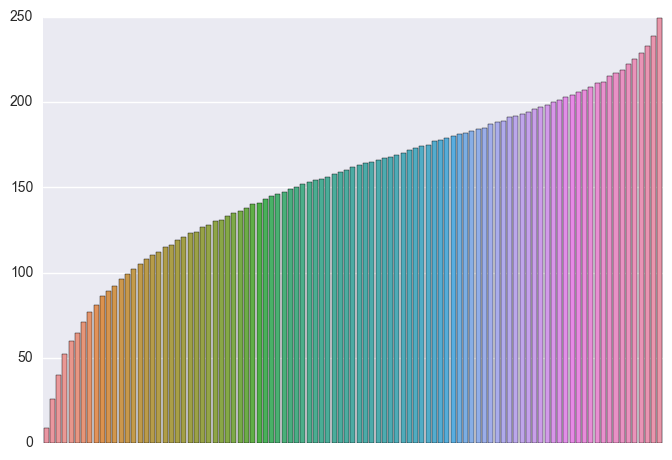

[ 124.  162.  191.  309.]


In [26]:
# Here we plot the count, that is the amount of records in the dataset, which
# translates to the amount of times that a bicycle was used.
plot_percentiles(bikes['tripduration'].count())

We see that the individual bycicles are used very much unevenly, with maximum being 309 and mean being 162 times. Keep in mind that we are only analyzing the data set of trips made in July 2013.

It poses interset to see the heatmap of the start and end location of trips with bikes.

In [20]:
# Load the requried module for displaying the map. 
from bokeh.plotting import figure, output_notebook, show
output_notebook()

Loading BokehJS ...

In [21]:
NYC = x_range, y_range = ((-8242000,-8210000), (4965000,4990000))

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
    
options = dict(line_color=None, fill_color='blue', size=5)

In [34]:
# Load the map of NYC
from bokeh.tile_providers import STAMEN_TERRAIN

samples = data.sample(n=1000) # Sample 1000 datapoints in order to receive meaningful, uncluttered map.
p = base_plot()
p.add_tile(STAMEN_TERRAIN)
p.circle(x=samples['start station longitude'], y=samples['start station latitude'], **options)
show(p)


We see that the coordinates must yet be recoded in Web Mercator, as right now our datapoints are being mapped on the equator near the coast of Gabon

In [ ]:
# To do: recode the coordinates in Web Mercator.